In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import sqlalchemy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as st
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [12]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [13]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)


In [16]:

columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [17]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
#checking my work
print(most_recent)

2017-08-23


In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
date = dt.datetime.strptime(most_recent, '%Y-%m-%d') - dt.timedelta(days=365)
print(date)
# Perform a query to retrieve the data and precipitation scores
qry = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= most_recent).\
        filter(Measurement.date >= date)

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(qry, columns=['date', 'prcp'])
df.set_index('date', inplace=True)
df=df.rename(columns={'prcp' : 'Precipitation'})
df.head()
# Sort the dataframe by date
sorted_df=df.sort_values(by = 'date')
sorted_df.head()

2016-08-23 00:00:00


,Precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


<function matplotlib.pyplot.show(close=None, block=None)>

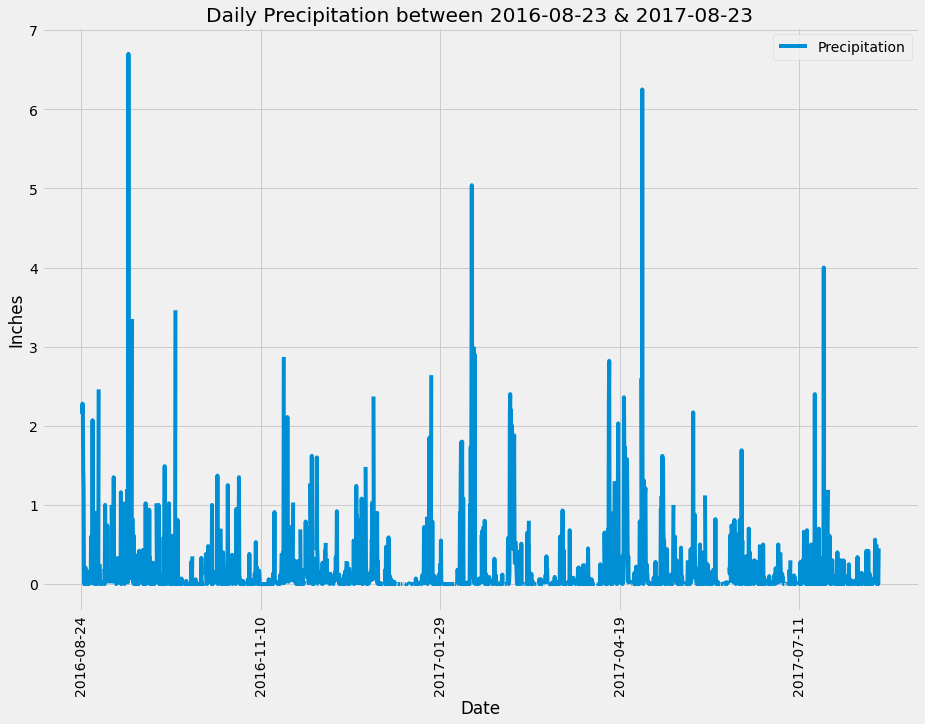

In [31]:
# Use Pandas Plotting with Matplotlib to plot the data
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%')

sorted_df.plot.line(rot=90, figsize=(14,10))
plt.style.use('fivethirtyeight')
plt.title('Daily Precipitation between 2016-08-23 & 2017-08-23')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.tight_layout
plt.show

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
#cumulative
sorted_df.agg({"Precipitation":["min", "max","mean", "median", "var", "std"]})

,Precipitation
min,0.000000
max,6.700000
mean,0.176462
median,0.020000
var,0.211865
std,0.460288


In [21]:
#by date
sum_stats= sorted_df.groupby(["date"]).agg({"Precipitation":["min", "max", "median", "var", "std"]})
sum_stats.head()

Precipitation                                 
                     min   max median       var       std
date                                                     
2016-08-24          0.08  2.28  1.800  0.706510  0.840541
2016-08-25          0.00  0.21  0.080  0.005157  0.071813
2016-08-26          0.00  0.04  0.015  0.000267  0.016330
2016-08-27          0.00  0.18  0.020  0.006680  0.081731
2016-08-28          0.01  2.07  0.140  0.620427  0.787672

# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset
station_analysis = session.query(Station.id).count()
print(station_analysis)

9


In [23]:
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [24]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
print(active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station,
      func.avg(Measurement.tobs),
      func.min(Measurement.tobs),
      func.max(Measurement.tobs)]
poppin_station = session.query(*sel).\
    group_by(Measurement.station).\
    filter(Measurement.station =="USC00519281").all()
poppin_station_df = pd.DataFrame(poppin_station, columns =['station','avg', 'min', 'max'])
poppin_station_df.set_index('station', inplace=True)
poppin_station_df

,avg,min,max
station,,,
USC00519281,71.663781,54.0,85.0


In [33]:
poppin_station

[('USC00519281', 71.66378066378067, 54.0, 85.0)]

In [41]:
# Using the most active station id
poppin_station_id = poppin_station[0][0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
poppin_station_id_qry = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date <= most_recent).\
        filter(Measurement.date >= date).filter(Measurement.station==poppin_station_id)

In [43]:
df2 = pd.DataFrame(poppin_station_id_qry, columns=['date', 'tobs'])
df2

,date,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
...,...,...
346,USC00519281,77.0
347,USC00519281,77.0
348,USC00519281,76.0
349,USC00519281,76.0


<function matplotlib.pyplot.show(close=None, block=None)>

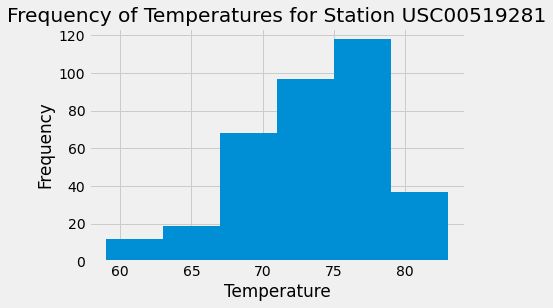

In [50]:
data_values = df2["tobs"].tolist()

bins = 12

fig, axs = plt.subplots()
axs.hist(data_values, bins=bins)
plt.title(f'Frequency of Temperatures for Station {poppin_station_id}')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.tight_layout
plt.show

# Close session

In [ ]:
# Close Session
session.close()